In [1]:
# import standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic lines
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import my scripts
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    scripts_path = os.path.join(module_path, "scripts")
    if scripts_path not in sys.path:
        sys.path.append(scripts_path)
    display(sys.path)
   
from data import get_data
from preprocessing import preprocess, add_new_columns

['/home/louis/code/lewagon/data/04-Decision-Science/01-Project-Setup/context-and-setup',
 '/home/louis/code/JammyNinja/Sandbox/chess_analysis/explore/notebooks',
 '/home/louis/.pyenv/versions/3.10.6/lib/python310.zip',
 '/home/louis/.pyenv/versions/3.10.6/lib/python3.10',
 '/home/louis/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload',
 '',
 '/home/louis/.pyenv/versions/3.10.6/envs/chess_analysis/lib/python3.10/site-packages',
 '/home/louis/code/JammyNinja/Sandbox/chess_analysis/explore/scripts']

In [3]:
fname = "all_games_2023-01_to_2025-01_all_new_cols.csv"
path = os.path.join("..", "data", fname)
raw_df = pd.read_csv(path)
raw_df.head(3)

,date,start_time,end_time,time_class,time_control,rated,rules,url,moves,opening_code,...,winner_pawns_count,loser_pawns_count,winner_pieces_only_count,loser_pieces_only_count,pieces_count_diff,pawns_count_diff,winner_material_ttl,loser_material_ttl,winner_pcs,loser_pcs
0,2023-01-07,2023-01-07 08:17:06,2023-01-07 14:35:53,daily,1/604800,True,chess,https://www.chess.com/game/daily/437377841,1. e4 {[%clk 158:31:38] 1... c6 {[%clk 163:21:...,B10,...,6,6,5,4,1,0,31,22,"['r', 'k', 'r', 'p', 'p', 'p', 'p', 'p', 'q', ...","['P', 'P', 'B', 'P', 'P', 'P', 'P', 'K', 'R', ..."
1,2023-01-14,2023-01-14 11:34:48,2023-01-14 15:09:28,daily,1/604800,True,chess,https://www.chess.com/game/daily/448245095,1. e4 {[%clk 167:35:57] 1... c5 {[%clk 165:23:...,B22,...,5,6,6,6,0,-1,33,34,"['r', 'q', 'r', 'b', 'b', 'p', 'k', 'p', 'p', ...","['B', 'Q', 'P', 'N', 'P', 'P', 'P', 'P', 'P', ..."
2,2023-01-30,2023-01-30 17:32:36,2023-01-30 07:50:02,daily,1/604800,True,chess,https://www.chess.com/game/daily/436095119,1. e4 {[%clk 167:38:55] 1... c6 {[%clk 163:21:...,B10,...,7,7,3,3,0,0,20,20,"['r', 'r', 'k', 'n', 'p', 'p', 'p', 'p', 'p', ...","['P', 'P', 'P', 'R', 'P', 'P', 'N', 'P', 'P', ..."


In [6]:
#exclude daily games and non chess
pre_filter_n_games = len(raw_df)
raw_df = raw_df.query('time_class != "daily"')
raw_df = raw_df.query('rules == "chess"')
post_filter_n_games = len(raw_df)
print(f"{pre_filter_n_games - post_filter_n_games } games excluded, {post_filter_n_games} left remaining.")

0 games excluded, 5879 left remaining.


## analysis ideas to tell if a game might be a highight (worth an ego-stroking replay)

<!-- ## How to tell if a game is worth highlighting/rewtch? -->

- Resigned with material count not that imbalanced
- checkmate in less than X moves (20?)
- checkmate with low on the clock

factors:
- checkmate/resigned = potential highlight
- when you have lower material
- higher rated opponent
- mated with a pawn!++ (or king move rly, incl castling, myb esp cstl in last moves?)
- make a factor out of your clock compared to your opponent's
- were lots of captures made in the last X moves?
- if the last Y moves were you moving your King
- were the lots of checks in the last Z moves?

Top X highlight games likely cool to rewatch (+ link to them)

Even links to your top 5 checkmates with each piece 

This is gold + deliverable

wins with <1 sec on your clock!

----

time scramble only most entertaining wins?
- lots of caputres
- both low on clock
- many moves made with low time?

In [7]:
[col for col in raw_df.columns if not "stl" in col]

['date',
 'start_time',
 'end_time',
 'time_class',
 'time_control',
 'rated',
 'rules',
 'url',
 'moves',
 'opening_code',
 'opening_name',
 'white_username',
 'black_username',
 'white_clock',
 'black_clock',
 'white_rating',
 'black_rating',
 'result',
 'white_result',
 'black_result',
 'winner',
 'user_win',
 'user_colour',
 'user_rating',
 'user_rating_diff',
 'higher_rated_colour',
 'winner_rating_diff',
 'move_numbers',
 'white_moves',
 'black_moves',
 'final_position_fen',
 'winner_ttl_pieces_count',
 'loser_ttl_pieces_count',
 'winner_pawns_count',
 'loser_pawns_count',
 'winner_pieces_only_count',
 'loser_pieces_only_count',
 'pieces_count_diff',
 'pawns_count_diff',
 'winner_material_ttl',
 'loser_material_ttl',
 'winner_pcs',
 'loser_pcs']

#### preprocessing

drop/create columns as necessary

In [8]:
# prep list of cols to extract
test_cols = ['time_class',  'user_colour', 
                'user_rating', 'opp_rating', 'user_rating_diff',
                'user_result', 'opp_result', 
                "user_win", "is_draw",
                'user_moves', 'opp_moves',
                'user_clock', 'opp_clock',
                'final_position_fen', 'url'
            ]

In [9]:
def highlight_preproc(df):

    clean_df = df.copy()
    
    clean_df['user_result'] = df.apply(lambda row : row["white_result"] if row['user_colour'] == "white" else row['black_result'],axis=1)
    clean_df['opp_result']  = df.apply(lambda row : row["white_result"] if row['user_colour'] == "black" else row['black_result'],axis=1)
    
    clean_df['user_win']    = clean_df.apply(lambda row : 1 if row['user_result'] == 'win' else 0, axis=1)
    clean_df['is_draw']     = clean_df.apply(lambda row : 1 if row['user_result'] == row['opp_result'] else 0, axis=1)
                                            
    clean_df["opp_rating"]  = df.apply(lambda row : row["white_rating"] if row['user_colour'] == "black" else row['black_rating'], axis=1)

    clean_df["user_clock"]  = df.apply(lambda row : row["white_clock"] if row['user_colour'] == "white" else row['black_clock'],axis=1)
    clean_df["opp_clock"]   = df.apply(lambda row : row["white_clock"] if row['user_colour'] == "black" else row['black_clock'],axis=1)

    clean_df["user_moves"]  = df.apply(lambda row : row["white_moves"] if row['user_colour'] == "white" else row['black_moves'],axis=1)
    clean_df["opp_moves"]   = df.apply(lambda row : row["white_moves"] if row['user_colour'] == "black" else row['black_moves'],axis=1)
    
    return clean_df
    
#process some columns
df = highlight_preproc(raw_df)[test_cols]
# df.apply(lambda row : row["white_result"] if row['user_colour'] == "white" else row["black_result"], axis=1)
df.query("user_rating_diff < -50 and user_result == 'win'")
df

,time_class,user_colour,user_rating,opp_rating,user_rating_diff,user_result,opp_result,user_win,is_draw,user_moves,opp_moves,user_clock,opp_clock,final_position_fen,url
3,blitz,black,1030,1022,8,timeout,win,0,0,"['d5', 'dxc4', 'b5', 'Bd7', 'Bxb5', 'Ba6', 'cx...","['Nf3', 'c4', 'e4', 'a4', 'axb5', 'Nc3', 'b3',...","['0:04:58', '0:04:56', '0:04:47.6', '0:04:42.5...","['0:04:54.9', '0:04:53.1', '0:04:50.9', '0:04:...",8/8/4K3/8/8/8/4Q3/6k1 b - -,https://www.chess.com/game/live/68853253455
5,blitz,black,1057,999,58,win,resigned,1,0,"['e5', 'Nc6', 'd5', 'Qxd5', 'Qc5', 'Qb4+', 'Qx...","['e4', 'd3', 'c3', 'exd5', 'c4', 'Be3', 'Bd2',...","['0:04:59.9', '0:04:56', '0:04:49.8', '0:04:47...","['0:05:00', '0:04:59.2', '0:04:55.3', '0:04:47...",8/ppp3p1/6P1/3n4/k7/2r5/4K3/8 w - -,https://www.chess.com/game/live/72649318887
9,blitz,black,1036,1158,-122,timeout,win,0,0,"['c6', 'd5', 'Bf5', 'h6', 'e6', 'Ne7', 'Ng6', ...","['e4', 'd4', 'e5', 'Nf3', 'Bf4', 'Be2', 'Nbd2'...","['0:04:56.9', '0:04:54.9', '0:04:49.6', '0:04:...","['0:04:50.3', '0:04:48.7', '0:04:47.5', '0:04:...",8/7k/P6p/1P3Qp1/1r6/6P1/5P1P/R5K1 b - -,https://www.chess.com/game/live/73488582235
10,blitz,white,1034,1006,28,stalemate,stalemate,0,1,"['e4', 'Nf3', 'd4', 'Qxd4', 'Qxg7', 'Qxf6', 'N...","['e5', 'Bd6', 'exd4', 'Nc6', 'Qf6', 'Nxf6', 'N...","['0:05:00', '0:04:58', '0:04:54.3', '0:04:50',...","['0:04:58.7', '0:04:57.4', '0:04:55.4', '0:04:...",r7/3K4/r7/3nkn2/3nn3/8/b7/8 w - -,https://www.chess.com/game/live/73819849367
11,rapid,white,1257,1167,90,win,checkmated,1,0,"['d4', 'c4', 'Nf3', 'Nxd4', 'Nc2', 'e3', 'Bd2'...","['Nf6', 'c5', 'cxd4', 'e5', 'Bc5', 'Nc6', 'Ne4...","['0:10:04.2', '0:10:03', '0:10:03.3', '0:10:03...","['0:09:57.9', '0:10:01', '0:09:42.3', '0:09:44...",8/R5Qk/7p/1P2p3/3p2pK/8/7P/6r1 b - -,https://www.chess.com/game/live/74361801303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5919,bullet,white,1416,1415,1,win,checkmated,1,0,"['e4', 'Nc3', 'Bc4', 'Qf3', 'Nh3', 'd3', 'Bg5'...","['e5', 'Nc6', 'Bc5', 'Nf6', 'O-O', 'd6', 'Be6'...","['0:01:00', '0:00:59.6', '0:00:59.2', '0:00:58...","['0:01:00', '0:00:59.4', '0:00:58.8', '0:00:57...",5kQ1/prr5/3pK2P/4p3/3bP3/3P4/PP6/6R1 b - - 2 35,https://www.chess.com/game/live/130452687369
5920,bullet,black,1424,1399,25,win,checkmated,1,0,"['d5', 'dxe4', 'e6', 'Bb4', 'Nc6', 'Bxd2+', 'N...","['f4', 'e4', 'd3', 'Nc3', 'Bd2', 'Nxe4', 'Qxd2...","['0:01:00', '0:00:58.8', '0:00:56.4', '0:00:52...","['0:01:00', '0:00:59.9', '0:00:58.8', '0:00:56...",r1b2Q2/ppp5/2k1p3/8/3PKPP1/4q1N1/PPn4P/5BNR w ...,https://www.chess.com/game/live/130453213637
5921,bullet,black,1433,1453,-20,win,checkmated,1,0,"['d5', 'Qxd5', 'Qd8', 'Nf6', 'Bf5', 'e6', 'Bg6...","['e4', 'exd5', 'd4', 'Be3', 'c4', 'Nc3', 'Bd3'...","['0:01:00', '0:00:59.9', '0:00:59.8', '0:00:59...","['0:01:00', '0:00:59.1', '0:00:59', '0:00:57.8...",8/8/6p1/8/3P4/P4kP1/7P/1r4K1 w - - 0 40,https://www.chess.com/game/live/130453262939
5922,bullet,white,1425,1445,-20,checkmated,win,0,0,"['e4', 'd4', 'Nc3', 'Be3', 'Bd3', 'Nge2', 'h4'...","['d6', 'e6', 'Nd7', 'Be7', 'Ngf6', 'O-O', 'e5'...","['0:01:00', '0:00:59', '0:00:57.7', '0:00:56.6...","['0:01:00', '0:00:59.9', '0:00:59.8', '0:00:59...",q5k1/K1p3p1/Ppq4p/2P4P/8/8/1P4P1/8 w - - 1 43,https://www.chess.com/game/live/130453779001


# white v black

In [ ]:
import pandas as pd

In [12]:
df.groupby("user_colour")['user_win'].mean()

user_colour
black    0.480586
white    0.524975
Name: user_win, dtype: float64

In [13]:
df

,time_class,user_colour,user_rating,opp_rating,user_rating_diff,user_result,opp_result,user_win,is_draw,user_moves,opp_moves,user_clock,opp_clock,final_position_fen,url
3,blitz,black,1030,1022,8,timeout,win,0,0,"['d5', 'dxc4', 'b5', 'Bd7', 'Bxb5', 'Ba6', 'cx...","['Nf3', 'c4', 'e4', 'a4', 'axb5', 'Nc3', 'b3',...","['0:04:58', '0:04:56', '0:04:47.6', '0:04:42.5...","['0:04:54.9', '0:04:53.1', '0:04:50.9', '0:04:...",8/8/4K3/8/8/8/4Q3/6k1 b - -,https://www.chess.com/game/live/68853253455
5,blitz,black,1057,999,58,win,resigned,1,0,"['e5', 'Nc6', 'd5', 'Qxd5', 'Qc5', 'Qb4+', 'Qx...","['e4', 'd3', 'c3', 'exd5', 'c4', 'Be3', 'Bd2',...","['0:04:59.9', '0:04:56', '0:04:49.8', '0:04:47...","['0:05:00', '0:04:59.2', '0:04:55.3', '0:04:47...",8/ppp3p1/6P1/3n4/k7/2r5/4K3/8 w - -,https://www.chess.com/game/live/72649318887
9,blitz,black,1036,1158,-122,timeout,win,0,0,"['c6', 'd5', 'Bf5', 'h6', 'e6', 'Ne7', 'Ng6', ...","['e4', 'd4', 'e5', 'Nf3', 'Bf4', 'Be2', 'Nbd2'...","['0:04:56.9', '0:04:54.9', '0:04:49.6', '0:04:...","['0:04:50.3', '0:04:48.7', '0:04:47.5', '0:04:...",8/7k/P6p/1P3Qp1/1r6/6P1/5P1P/R5K1 b - -,https://www.chess.com/game/live/73488582235
10,blitz,white,1034,1006,28,stalemate,stalemate,0,1,"['e4', 'Nf3', 'd4', 'Qxd4', 'Qxg7', 'Qxf6', 'N...","['e5', 'Bd6', 'exd4', 'Nc6', 'Qf6', 'Nxf6', 'N...","['0:05:00', '0:04:58', '0:04:54.3', '0:04:50',...","['0:04:58.7', '0:04:57.4', '0:04:55.4', '0:04:...",r7/3K4/r7/3nkn2/3nn3/8/b7/8 w - -,https://www.chess.com/game/live/73819849367
11,rapid,white,1257,1167,90,win,checkmated,1,0,"['d4', 'c4', 'Nf3', 'Nxd4', 'Nc2', 'e3', 'Bd2'...","['Nf6', 'c5', 'cxd4', 'e5', 'Bc5', 'Nc6', 'Ne4...","['0:10:04.2', '0:10:03', '0:10:03.3', '0:10:03...","['0:09:57.9', '0:10:01', '0:09:42.3', '0:09:44...",8/R5Qk/7p/1P2p3/3p2pK/8/7P/6r1 b - -,https://www.chess.com/game/live/74361801303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5919,bullet,white,1416,1415,1,win,checkmated,1,0,"['e4', 'Nc3', 'Bc4', 'Qf3', 'Nh3', 'd3', 'Bg5'...","['e5', 'Nc6', 'Bc5', 'Nf6', 'O-O', 'd6', 'Be6'...","['0:01:00', '0:00:59.6', '0:00:59.2', '0:00:58...","['0:01:00', '0:00:59.4', '0:00:58.8', '0:00:57...",5kQ1/prr5/3pK2P/4p3/3bP3/3P4/PP6/6R1 b - - 2 35,https://www.chess.com/game/live/130452687369
5920,bullet,black,1424,1399,25,win,checkmated,1,0,"['d5', 'dxe4', 'e6', 'Bb4', 'Nc6', 'Bxd2+', 'N...","['f4', 'e4', 'd3', 'Nc3', 'Bd2', 'Nxe4', 'Qxd2...","['0:01:00', '0:00:58.8', '0:00:56.4', '0:00:52...","['0:01:00', '0:00:59.9', '0:00:58.8', '0:00:56...",r1b2Q2/ppp5/2k1p3/8/3PKPP1/4q1N1/PPn4P/5BNR w ...,https://www.chess.com/game/live/130453213637
5921,bullet,black,1433,1453,-20,win,checkmated,1,0,"['d5', 'Qxd5', 'Qd8', 'Nf6', 'Bf5', 'e6', 'Bg6...","['e4', 'exd5', 'd4', 'Be3', 'c4', 'Nc3', 'Bd3'...","['0:01:00', '0:00:59.9', '0:00:59.8', '0:00:59...","['0:01:00', '0:00:59.1', '0:00:59', '0:00:57.8...",8/8/6p1/8/3P4/P4kP1/7P/1r4K1 w - - 0 40,https://www.chess.com/game/live/130453262939
5922,bullet,white,1425,1445,-20,checkmated,win,0,0,"['e4', 'd4', 'Nc3', 'Be3', 'Bd3', 'Nge2', 'h4'...","['d6', 'e6', 'Nd7', 'Be7', 'Ngf6', 'O-O', 'e5'...","['0:01:00', '0:00:59', '0:00:57.7', '0:00:56.6...","['0:01:00', '0:00:59.9', '0:00:59.8', '0:00:59...",q5k1/K1p3p1/Ppq4p/2P4P/8/8/1P4P1/8 w - - 1 43,https://www.chess.com/game/live/130453779001


### Performance against higher rated players

bar chart showing win % against players every 10 rating points diff

In [8]:
rating_bins = np.arange(-100, 100, 5)
min_diff, max_diff = np.array(-500) , np.array(500)
rating_edges = np.insert(np.array([min_diff,max_diff]),1, rating_bins)
rating_edges

array([-500, -100,  -95,  -90,  -85,  -80,  -75,  -70,  -65,  -60,  -55,
        -50,  -45,  -40,  -35,  -30,  -25,  -20,  -15,  -10,   -5,    0,
          5,   10,   15,   20,   25,   30,   35,   40,   45,   50,   55,
         60,   65,   70,   75,   80,   85,   90,   95,  500])

In [9]:
df['rating_diff_bin'] = pd.cut(df['user_rating_diff'], bins=rating_edges)
df.head(2)

,time_class,user_colour,user_win,user_result,opp_result,user_rating,opp_rating,user_rating_diff,user_moves,opp_moves,user_clock,opp_clock,final_position_fen,url,rating_diff_bin
3,blitz,black,0,timeout,win,1030,1022,8,"['d5', 'dxc4', 'b5', 'Bd7', 'Bxb5', 'Ba6', 'cx...","['Nf3', 'c4', 'e4', 'a4', 'axb5', 'Nc3', 'b3',...","['0:04:58', '0:04:56', '0:04:47.6', '0:04:42.5...","['0:04:54.9', '0:04:53.1', '0:04:50.9', '0:04:...",8/8/4K3/8/8/8/4Q3/6k1 b - -,https://www.chess.com/game/live/68853253455,"(5, 10]"
5,blitz,black,1,win,resigned,1057,999,58,"['e5', 'Nc6', 'd5', 'Qxd5', 'Qc5', 'Qb4+', 'Qx...","['e4', 'd3', 'c3', 'exd5', 'c4', 'Be3', 'Bd2',...","['0:04:59.9', '0:04:56', '0:04:49.8', '0:04:47...","['0:05:00', '0:04:59.2', '0:04:55.3', '0:04:47...",8/ppp3p1/6P1/3n4/k7/2r5/4K3/8 w - -,https://www.chess.com/game/live/72649318887,"(55, 60]"


In [10]:
# save excluded rows
na_df = df[df['rating_diff_bin'].isna()]

#move on without them
df = df.dropna(subset = 'rating_diff_bin')

In [11]:
len(df)

5807

In [24]:
draw_mask = df['user_result'] == df["opp_result"]
df[draw_mask]

,time_class,user_colour,user_win,user_result,opp_result,user_rating,opp_rating,user_rating_diff,user_moves,opp_moves,user_clock,opp_clock,final_position_fen,url,rating_diff_bin
10,blitz,white,0,stalemate,stalemate,1034,1006,28,"['e4', 'Nf3', 'd4', 'Qxd4', 'Qxg7', 'Qxf6', 'N...","['e5', 'Bd6', 'exd4', 'Nc6', 'Qf6', 'Nxf6', 'N...","['0:05:00', '0:04:58', '0:04:54.3', '0:04:50',...","['0:04:58.7', '0:04:57.4', '0:04:55.4', '0:04:...",r7/3K4/r7/3nkn2/3nn3/8/b7/8 w - -,https://www.chess.com/game/live/73819849367,"(25, 30]"
69,blitz,white,0,timevsinsufficient,timevsinsufficient,1006,1027,-21,"['e4', 'd4', 'e5', 'g4', 'f4', 'Be2', 'c3', 'B...","['c6', 'd5', 'Bf5', 'Bd7', 'e6', 'c5', 'Nc6', ...","['0:05:00', '0:04:58.6', '0:04:58.3', '0:04:50...","['0:05:00', '0:04:59.1', '0:04:57.4', '0:04:40...",8/1k6/2n2K2/8/8/8/8/4q3 b - -,https://www.chess.com/game/live/91808420829,"(-25, -20]"
70,blitz,black,0,repetition,repetition,1007,1027,-20,"['d5', 'Nc6', 'Nf6', 'Ne4', 'f5', 'Bd7', 'fxe4...","['d4', 'Bf4', 'Nf3', 'e3', 'Nbd2', 'Bb5', 'Nxe...","['0:04:58.5', '0:04:53.4', '0:04:41.6', '0:04:...","['0:04:50.8', '0:04:46', '0:04:44.2', '0:04:16...",5r2/1kp5/2p5/p2p2p1/Pb1Pp1Pp/1P2Pr1P/R1R2PKB/8...,https://www.chess.com/game/live/91809008345,"(-25, -20]"
74,blitz,white,0,timevsinsufficient,timevsinsufficient,1015,956,59,"['e4', 'd4', 'f3', 'Nc3', 'Qd3', 'a3', 'bxc3',...","['b6', 'Bb7', 'e6', 'Bb4', 'Ne7', 'Bxc3+', 'f6...","['0:04:59.9', '0:04:56.3', '0:04:55.5', '0:04:...","['0:04:59.9', '0:04:58.7', '0:04:56.5', '0:04:...",8/8/8/7K/5k2/p7/8/8 b - -,https://www.chess.com/game/live/91810764821,"(55, 60]"
104,blitz,white,0,stalemate,stalemate,993,997,-4,"['d4', 'f4', 'Nd2', 'e3', 'Bd3', 'c3', 'Ngf3',...","['d5', 'Nf6', 'g6', 'Bg7', 'O-O', 'Nbd7', 'c5'...","['0:05:00', '0:04:55.5', '0:04:49.6', '0:04:48...","['0:04:57.9', '0:04:57', '0:04:56.2', '0:04:54...",8/8/6k1/6p1/4p1K1/2b1r3/8/8 w - -,https://www.chess.com/game/live/92685124245,"(-5, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5706,blitz,white,0,stalemate,stalemate,1163,1141,22,"['e4', 'Nc3', 'd4', 'f4', 'fxe5', 'd5', 'Bd3',...","['g6', 'Bg7', 'd6', 'e5', 'dxe5', 'Nf6', 'O-O'...","['0:02:59.7', '0:02:58.5', '0:02:57.4', '0:02:...","['0:02:57.1', '0:02:57', '0:02:56.5', '0:02:49...",8/p4k1p/1p3b2/1P3K2/r7/8/8/8 w - -,https://www.chess.com/game/live/128180443949,"(20, 25]"
5713,bullet,white,0,stalemate,stalemate,1351,1373,-22,"['e4', 'Nc3', 'Bc4', 'd4', 'd5', 'Be3', 'Qd3',...","['d6', 'Nd7', 'Ngf6', 'e5', 'Be7', 'O-O', 'c6'...","['0:01:00', '0:00:59.5', '0:00:58.6', '0:00:54...","['0:01:00', '0:00:59.9', '0:00:59.8', '0:00:59...",8/5k1p/6p1/8/8/6q1/8/7K w - -,https://www.chess.com/game/live/128275223851,"(-25, -20]"
5771,bullet,white,0,stalemate,stalemate,1352,1362,-10,"['e4', 'Nc3', 'Bc4', 'd3', 'a3', 'Nxb5', 'Nxd6...","['d6', 'a6', 'e6', 'Be7', 'b5', 'Bb7', 'Bxd6',...","['0:01:00', '0:00:59.2', '0:00:58.1', '0:00:56...","['0:01:00', '0:00:59.9', '0:00:59.8', '0:00:59...",8/4n1k1/5p1p/p6K/r7/8/8/8 w - -,https://www.chess.com/game/live/129245595269,"(-15, -10]"
5804,bullet,white,0,timevsinsufficient,timevsinsufficient,1356,1407,-51,"['e4', 'Nc3', 'e5', 'd4', 'bxc3', 'Be3', 'Bd3'...","['e6', 'd5', 'Bb4', 'Bxc3+', 'Ne7', 'c5', 'cxd...","['0:01:00', '0:00:59.2', '0:00:57.6', '0:00:57...","['0:01:00', '0:00:59.9', '0:00:58.4', '0:00:58...",8/p6K/1p5p/r2r3k/8/8/3p4/4q3 b - -,https://www.chess.com/game/live/129549149483,"(-55, -50]"


In [26]:
agg_dict = {
    "user_win" : "mean",
    "user_colour" : "count"
}

In [27]:
win_rate_df = df.groupby(by='rating_diff_bin', observed=False)\
    .agg(agg_dict)\
    .rename(columns={"user_win" : "win_rate", "user_colour" : "n_games"})\
    .reset_index()
win_rate_df['rating_diff_label'] = win_rate_df['rating_diff_bin'].apply(lambda x : x.left)

In [14]:
win_rate_df

,rating_diff_bin,user_win,n_games,rating_diff_label
0,"(-500, -100]",0.038462,26,-500
1,"(-100, -95]",0.142857,7,-100
2,"(-95, -90]",0.333333,3,-95
3,"(-90, -85]",0.000000,6,-90
4,"(-85, -80]",0.000000,6,-85
5,"(-80, -75]",0.250000,12,-80
6,"(-75, -70]",0.166667,12,-75
7,"(-70, -65]",0.300000,20,-70
8,"(-65, -60]",0.020619,97,-65
9,"(-60, -55]",0.032609,92,-60


(0.0, 1.0)

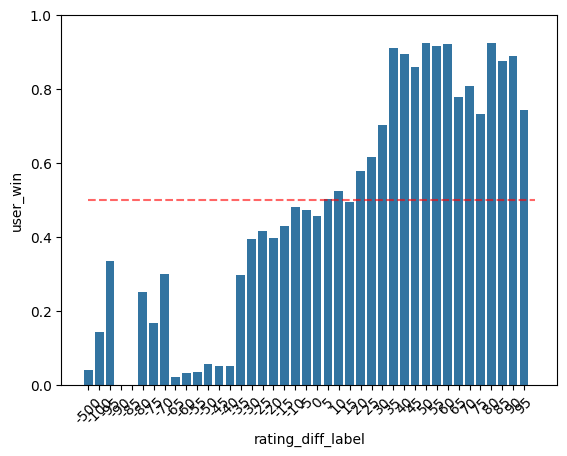

In [15]:
sns.barplot(data=win_rate_df, x='rating_diff_label', y="user_win")
plt.hlines(y=0.5,xmin=0,xmax=len(win_rate_df), color='r', ls='--', alpha=0.6)
plt.xticks(rotation=45);
plt.ylim(0,1)

In [16]:
#try with xaxis in center

win_rate_df['user_win_offset'] = win_rate_df['user_win']-0.5
win_rate_df

,rating_diff_bin,user_win,n_games,rating_diff_label,user_win_offset
0,"(-500, -100]",0.038462,26,-500,-0.461538
1,"(-100, -95]",0.142857,7,-100,-0.357143
2,"(-95, -90]",0.333333,3,-95,-0.166667
3,"(-90, -85]",0.000000,6,-90,-0.500000
4,"(-85, -80]",0.000000,6,-85,-0.500000
5,"(-80, -75]",0.250000,12,-80,-0.250000
6,"(-75, -70]",0.166667,12,-75,-0.333333
7,"(-70, -65]",0.300000,20,-70,-0.200000
8,"(-65, -60]",0.020619,97,-65,-0.479381
9,"(-60, -55]",0.032609,92,-60,-0.467391


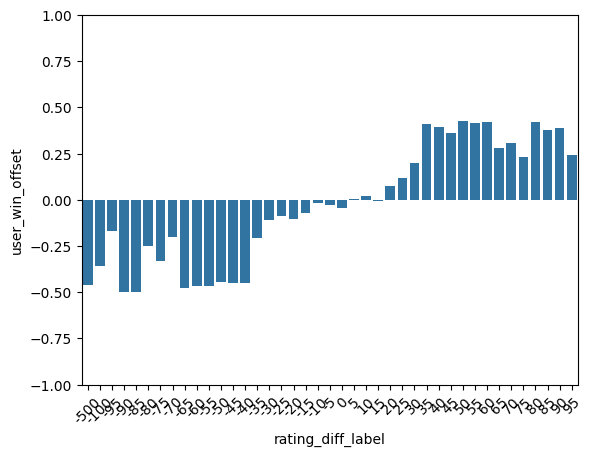

In [17]:
fig, ax = plt.subplots()
sns.barplot(data=win_rate_df, x='rating_diff_label', y="user_win_offset", ax=ax)
# plt.hlines(y=0,xmin=0,xmax=len(win_rate_df), color='r', ls='--', alpha=0.6)
plt.xticks(rotation=45);
plt.ylim(-1,1)
# ax.spines['bottom'].set_position('center')
ax.xaxis.set_ticks_position('bottom')
# plt.title("

# Moves

In [19]:
df

,time_class,user_colour,user_rating,opp_rating,user_rating_diff,user_result,opp_result,user_win,is_draw,user_moves,opp_moves,user_clock,opp_clock,final_position_fen,url
3,blitz,black,1030,1022,8,timeout,win,0,0,"['d5', 'dxc4', 'b5', 'Bd7', 'Bxb5', 'Ba6', 'cx...","['Nf3', 'c4', 'e4', 'a4', 'axb5', 'Nc3', 'b3',...","['0:04:58', '0:04:56', '0:04:47.6', '0:04:42.5...","['0:04:54.9', '0:04:53.1', '0:04:50.9', '0:04:...",8/8/4K3/8/8/8/4Q3/6k1 b - -,https://www.chess.com/game/live/68853253455
5,blitz,black,1057,999,58,win,resigned,1,0,"['e5', 'Nc6', 'd5', 'Qxd5', 'Qc5', 'Qb4+', 'Qx...","['e4', 'd3', 'c3', 'exd5', 'c4', 'Be3', 'Bd2',...","['0:04:59.9', '0:04:56', '0:04:49.8', '0:04:47...","['0:05:00', '0:04:59.2', '0:04:55.3', '0:04:47...",8/ppp3p1/6P1/3n4/k7/2r5/4K3/8 w - -,https://www.chess.com/game/live/72649318887
9,blitz,black,1036,1158,-122,timeout,win,0,0,"['c6', 'd5', 'Bf5', 'h6', 'e6', 'Ne7', 'Ng6', ...","['e4', 'd4', 'e5', 'Nf3', 'Bf4', 'Be2', 'Nbd2'...","['0:04:56.9', '0:04:54.9', '0:04:49.6', '0:04:...","['0:04:50.3', '0:04:48.7', '0:04:47.5', '0:04:...",8/7k/P6p/1P3Qp1/1r6/6P1/5P1P/R5K1 b - -,https://www.chess.com/game/live/73488582235
10,blitz,white,1034,1006,28,stalemate,stalemate,0,1,"['e4', 'Nf3', 'd4', 'Qxd4', 'Qxg7', 'Qxf6', 'N...","['e5', 'Bd6', 'exd4', 'Nc6', 'Qf6', 'Nxf6', 'N...","['0:05:00', '0:04:58', '0:04:54.3', '0:04:50',...","['0:04:58.7', '0:04:57.4', '0:04:55.4', '0:04:...",r7/3K4/r7/3nkn2/3nn3/8/b7/8 w - -,https://www.chess.com/game/live/73819849367
11,rapid,white,1257,1167,90,win,checkmated,1,0,"['d4', 'c4', 'Nf3', 'Nxd4', 'Nc2', 'e3', 'Bd2'...","['Nf6', 'c5', 'cxd4', 'e5', 'Bc5', 'Nc6', 'Ne4...","['0:10:04.2', '0:10:03', '0:10:03.3', '0:10:03...","['0:09:57.9', '0:10:01', '0:09:42.3', '0:09:44...",8/R5Qk/7p/1P2p3/3p2pK/8/7P/6r1 b - -,https://www.chess.com/game/live/74361801303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5919,bullet,white,1416,1415,1,win,checkmated,1,0,"['e4', 'Nc3', 'Bc4', 'Qf3', 'Nh3', 'd3', 'Bg5'...","['e5', 'Nc6', 'Bc5', 'Nf6', 'O-O', 'd6', 'Be6'...","['0:01:00', '0:00:59.6', '0:00:59.2', '0:00:58...","['0:01:00', '0:00:59.4', '0:00:58.8', '0:00:57...",5kQ1/prr5/3pK2P/4p3/3bP3/3P4/PP6/6R1 b - - 2 35,https://www.chess.com/game/live/130452687369
5920,bullet,black,1424,1399,25,win,checkmated,1,0,"['d5', 'dxe4', 'e6', 'Bb4', 'Nc6', 'Bxd2+', 'N...","['f4', 'e4', 'd3', 'Nc3', 'Bd2', 'Nxe4', 'Qxd2...","['0:01:00', '0:00:58.8', '0:00:56.4', '0:00:52...","['0:01:00', '0:00:59.9', '0:00:58.8', '0:00:56...",r1b2Q2/ppp5/2k1p3/8/3PKPP1/4q1N1/PPn4P/5BNR w ...,https://www.chess.com/game/live/130453213637
5921,bullet,black,1433,1453,-20,win,checkmated,1,0,"['d5', 'Qxd5', 'Qd8', 'Nf6', 'Bf5', 'e6', 'Bg6...","['e4', 'exd5', 'd4', 'Be3', 'c4', 'Nc3', 'Bd3'...","['0:01:00', '0:00:59.9', '0:00:59.8', '0:00:59...","['0:01:00', '0:00:59.1', '0:00:59', '0:00:57.8...",8/8/6p1/8/3P4/P4kP1/7P/1r4K1 w - - 0 40,https://www.chess.com/game/live/130453262939
5922,bullet,white,1425,1445,-20,checkmated,win,0,0,"['e4', 'd4', 'Nc3', 'Be3', 'Bd3', 'Nge2', 'h4'...","['d6', 'e6', 'Nd7', 'Be7', 'Ngf6', 'O-O', 'e5'...","['0:01:00', '0:00:59', '0:00:57.7', '0:00:56.6...","['0:01:00', '0:00:59.9', '0:00:59.8', '0:00:59...",q5k1/K1p3p1/Ppq4p/2P4P/8/8/1P4P1/8 w - - 1 43,https://www.chess.com/game/live/130453779001


In [18]:
df['user_moves'].iloc[0]

"['d5', 'dxc4', 'b5', 'Bd7', 'Bxb5', 'Ba6', 'cxb3', 'Nxa6', 'Qd3', 'Qxa6', 'Qxb5', 'O-O-O', 'Kb7', 'Ra8', 'Nf6', 'Ra1', 'Nd7', 'Nxe5', 'Nd3', 'e6', 'f5', 'Nc5', 'Nb3', 'Rxf1+', 'Nxd2+', 'Nc4', 'Rg8', 'Bb4+', 'Rh8', 'Rxh2+', 'g6', 'Bd6', 'Nd2+', 'Ne4', 'fxe4', 'Re2+', 'Kc6', 'Kc5', 'Kc4', 'c6', 'gxf5+', 'Be7', 'Kb3', 'Bf8', 'Kc2', 'c5', 'Bxc5', 'Kd2', 'Bb4', 'Ba3', 'Bd6', 'Ke3', 'Ba3', 'Ke4', 'Kd4', 'Bxe7', 'Ke4', 'Kd3', 'Ke3', 'Kd2', 'Ke2', 'Kf2', 'Kg2', 'Kf1', 'Kg1', nan]"